In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

C:\Users\prath\AppData\Local\Temp\ipykernel_28532\1858431299.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
c:\Users\prath\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


* Get the stock data from Yahoo finance as a CSV for any company. 
* Drop all other columns (Volume, Year, Month and Day) and retain Open, High and Close - since I'm just predicting the close value for a day

In [2]:
def get_stock_data(normalized=0):
    url = "historic_data/csv/TCS.NS.csv"
    col_names = ['Date','Open','High','Low','Close','Volume','Adj Close']
    stocks = pd.read_csv(url, header=0, names=col_names) 
    df = pd.DataFrame(stocks)
    date_split = df['Date'].str.split('-').str
    df['Year'], df['Month'], df['Day'] = date_split
    df["Volume"] = df["Volume"] / 10000
    return df

In [3]:
df = get_stock_data(0)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')


#sort by date
df = df.sort_values('Date')

# fix the date 
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)
df.tail()

C:\Users\prath\AppData\Local\Temp\ipykernel_28532\2441751676.py:7: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['Year'], df['Month'], df['Day'] = date_split


,index,Open,High,Low,Close,Volume,Adj Close,Year,Month,Day
Date,,,,,,,,,,
2023-03-27,5133,3106.000000,3135.000000,1524217.0,3152.750000,0.31223,3122.300049,27,03,2023
2023-03-28,5134,3110.149902,3127.000000,1303530.0,3149.550049,0.31159,3115.899902,28,03,2023
2023-03-29,5135,3104.100098,3129.000000,1740616.0,3150.000000,0.31389,3138.899902,29,03,2023
2023-03-31,5136,3152.000000,3189.949951,2382581.0,3213.000000,0.32059,3205.899902,31,03,2023
2023-04-03,5137,3173.750000,3224.949951,1521830.0,3224.949951,0.32000,3200.000000,03,04,2023


In [4]:
df.drop(df.columns[[0,3,6, 7,8,9]], axis=1, inplace=True)
df.head()

,Open,High,Close,Volume
Date,,,,
2002-08-12,38.724998,38.724998,40.000000,0.003970
2002-08-13,38.875000,39.750000,40.387501,0.003916
2002-08-14,35.724998,39.250000,39.250000,0.003646
2002-08-15,36.462502,36.462502,36.462502,0.003646
2002-08-16,35.750000,36.275002,38.000000,0.003638


<h2>Normalizing and removing the null data points</h2>

In [5]:
df['Open'] = df['Open']/100
df['High'] = df['High']/100
df['Volume'] = df['Volume']*100
df['Close'] = df['Close']/100
print(df)
nan_value_index = []
High = df.High.isnull()
for i in range(0, len(High)):
    if High[i] == 1:
        nan_value_index.append(i)
        df['High'][i] = 0
Open = df.Open.isnull()
for i in range(0, len(Open)):
    if Open[i] == 1:
        nan_value_index.append(i)
        df['Open'][i] = 0
Volume = df.Volume.isnull()
for i in range(0, len(Volume)):
    if Volume[i] == 1:
        nan_value_index.append(i)
        df['Volume'][i] = 0
Close = df.Close.isnull()
for i in range(0, len(Close)):
    if Close[i] == 1:
        nan_value_index.append(i)
        df['Close'][i] = 0

                 Open       High      Close     Volume
Date                                                  
2002-08-12   0.387250   0.387250   0.400000   0.397000
2002-08-13   0.388750   0.397500   0.403875   0.391625
2002-08-14   0.357250   0.392500   0.392500   0.364625
2002-08-15   0.364625   0.364625   0.364625   0.364625
2002-08-16   0.357500   0.362750   0.380000   0.363750
...               ...        ...        ...        ...
2023-03-27  31.060000  31.350000  31.527500  31.223000
2023-03-28  31.101499  31.270000  31.495500  31.158999
2023-03-29  31.041001  31.290000  31.500000  31.388999
2023-03-31  31.520000  31.899500  32.130000  32.058999
2023-04-03  31.737500  32.249500  32.249500  32.000000

[5138 rows x 4 columns]


In [6]:
X = df[['High','Open', 'Volume']]
Y = df[['Close']]
factor = 0.80
length = X.shape[0]
total_for_train = int(length*factor)
X_train = X[:total_for_train]
Y_train = Y[:total_for_train]
X_test = X[total_for_train:]
Y_test = Y[total_for_train:]

In [7]:
print("X_train", X_train.shape)
print("y_train", Y_train.shape)
print("X_test", X_test.shape)
print("y_test", Y_test.shape)

X_train (4110, 3)
y_train (4110, 1)
X_test (1028, 3)
y_test (1028, 1)


<h2>Compiling and training the neural network model</h2>

In [8]:
classifier = Sequential()
classifier.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 3))
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'linear'))
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = [])
classifier.fit(X_train, Y_train, batch_size = 128, epochs = 50, validation_split=0.05)

Epoch 1/50
31/31 [==============================] - 2s 17ms/step - loss: 53.9135 - val_loss: 354.0846
Epoch 2/50
31/31 [==============================] - 0s 5ms/step - loss: 47.0885 - val_loss: 265.5155
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 25.7119 - val_loss: 77.7215
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 3.2242 - val_loss: 0.0222
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.1653 - val_loss: 0.2459
Epoch 6/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0942 - val_loss: 0.3121
Epoch 7/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0865 - val_loss: 0.2555
Epoch 8/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0800 - val_loss: 0.2399
Epoch 9/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0737 - val_loss: 0.2168
Epoch 10/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0676 - val_loss: 0.2053
Epoch 11/5

<h2>Predicted Values</h2>

In [9]:
predictions = classifier.predict(X_test)
print(predictions[:10])

33/33 [==============================] - 0s 3ms/step
[[20.685965]
 [20.834915]
 [21.030577]
 [20.903673]
 [20.862516]
 [20.745956]
 [20.736134]
 [20.575075]
 [20.170704]
 [19.484077]]


Execute the trained model

<h2>Calculating the error in the trained Neural Network model</h2>

In [10]:
trainScore = classifier.evaluate(X_train, Y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = classifier.evaluate(X_test, Y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.06 RMSE)
Test Score: 0.04 MSE (0.20 RMSE)


<h2>Predictions vs Real results</h2>

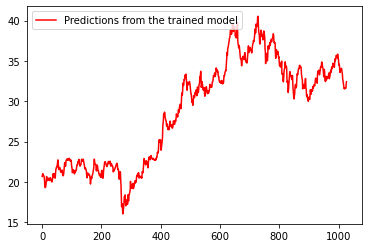

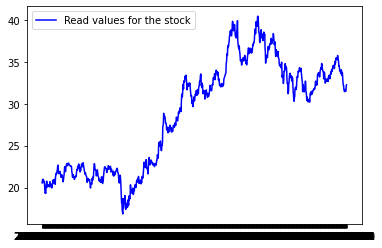

In [11]:
import matplotlib.pyplot as plt
plt.plot(predictions,color='red', label='Predictions from the trained model')
plt.legend(loc='upper left')
plt.show()
plt.plot(Y_test,color='blue', label='Read values for the stock')
plt.legend(loc='upper left')
plt.show()